In [1]:
# Libraries
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV 
from sklearn.linear_model import Perceptron, LogisticRegressionCV, RidgeClassifierCV, SGDClassifier, PassiveAggressiveClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score,mean_absolute_error, confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve, auc, classification_report,precision_score,recall_score,log_loss,f1_score
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, AdaBoostClassifier
from bayes_opt import BayesianOptimization
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, LabelEncoder, OneHotEncoder, MaxAbsScaler, RobustScaler, QuantileTransformer
from sklearn.svm import SVC
from sklearn import tree
import pandas_bokeh
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from numpy import mean, std
import pandas.testing as tm
from scipy import stats
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance

# Pipelines
import inspect
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

#other
from math import sqrt

import eli5


In [2]:
def hasmethod(obj, name):
    return inspect.ismethod(getattr(obj, name, None))

In [3]:
def setupPreprocessPipeline(scaler):
	ss = Pipeline(steps=[('scaler',scaler)])
	ohe = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown = 'ignore'))])
	preprocess = ColumnTransformer(
                    transformers=[
                        ('cont', ss, numerical_no_bool),
                        ('cat', ohe, categorical),
                        #('le', le, ordinal),
                        ],remainder='passthrough')
	return preprocess

def feature_importance(classifier, feature_names, scaler_name):
	if (hasattr(classifier,'coef_')):
		importance = classifier.coef_[0]
	elif (hasattr(classifier,'coefs_')):
		importance = classifier.coefs_
	elif (hasattr(classifier,'feature_importances_')):
		importance = classifier.feature_importances_
	else:
		print("Cannot extract feature importance, skipping")
		return

	for i,v in enumerate(importance):
		print('Feature: %d, Score: %.5f' % (i,v))
	zipped = zip(feature_names, importance)
	df = pd.DataFrame(zipped, columns=["feature", "value"])
	# Sort the features by the absolute value of their coefficient
	df["abs_value"] = df["value"].apply(lambda x: abs(x))
	df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
	df = df.sort_values("abs_value", ascending=False)
	# plot feature importance
	fig, ax = plt.subplots(1, 1, figsize=(16, 9))
	sns.barplot(x="feature",
	            y="value",
	            data=df.head(20),
	           palette=df.head(20)["colors"])
	plt.gcf().subplots_adjust(bottom=0.30)
	ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
	ax.set_title("Top 20 Features for {} w/ {}".format(classifier.__class__.__name__, scaler_name), fontsize=25)
	ax.set_ylabel("Coef", fontsize=22)
	ax.set_xlabel("Feature Name", fontsize=22)
	plt.show()

def evaluation(y, y_hat, title):
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    accuracy = accuracy_score(y,y_hat)
    f1 = f1_score(y,y_hat)
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    plt.show()


In [4]:

def metrics_summary(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    accuracy=accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall =  recall_score(y_test, y_pred) #sensitivity
    specificity = tn / (tn+fp)
    g_mean= sqrt(recall * specificity)
    mse =mean_squared_error(y_test, y_pred, squared=False)
    r2=r2_score(y_test, y_pred)
    ros = roc_auc_score(y_test, y_pred)
    ll = log_loss(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    metrics_collection_dict ={
        'accuracy':['accuracy',accuracy],
        'precision':['precision',precision],
        'recall':['recall',recall],
        'specificity':['specificity',specificity],
        'g_mean':['g_mean',g_mean],
        'mean_square_error':['mean_square_error',mse],
        'r2':['r2',r2],
        'roc_auc_score':['roc_auc_score',ros],
        'log_loss':['log_loss',ll],
        'f1_score':['f1_score',f1]
    } 
    return metrics_collection_dict

In [5]:
#ROC curve

def ROC_Curve_Plot(model,X_test,y_test):
    predProb = model.predict_proba(X_test)
    preds = predProb[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds,pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.close()
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    #plt.xlim([0, 1])
    #plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return fpr,tpr

LogisticRegressionCV
35
Recall:  0.5576923076923077
Accuracy:  0.8898809523809523
Precision:  0.6744186046511628
F1:  0.6105263157894736


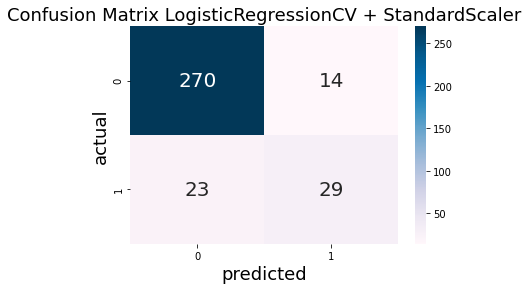

Mean Training Accuracy: 0.9029761904761905 | Standard Deviation: 0.009486534196731702
Mean Validation Accuracy: 0.893452380952381 | Standard Deviation: 0.009486534196731702


Feature: 0, Score: 0.61840
Feature: 1, Score: -0.22993
Feature: 2, Score: -0.00244
Feature: 3, Score: -0.57664
Feature: 4, Score: -0.99067
Feature: 5, Score: -0.37620
Feature: 6, Score: 0.02200
Feature: 7, Score: 0.42198
Feature: 8, Score: 0.11203
Feature: 9, Score: -0.08381
Feature: 10, Score: 0.06741
Feature: 11, Score: 0.39387
Feature: 12, Score: 0.36164
Feature: 13, Score: 0.29477
Feature: 14, Score: -0.30774
Feature: 15, Score: 0.18568
Feature: 16, Score: 0.06643
Feature: 17, Score: -0.55193
Feature: 18, Score: -1.18205
Feature: 19, Score: 0.11959
Feature: 20, Score: 0.36200
Feature: 21, Score: 0.36564
Feature: 22, Score: -0.78374
Feature: 23, Score: 0.51250
Feature: 24, Score: -0.84287
Feature: 25, Score: 0.56395
Feature: 26, Score: -0.29157
Feature: 27, Score: -0.00169
Feature: 28, Score: 2.51087
Feature: 2

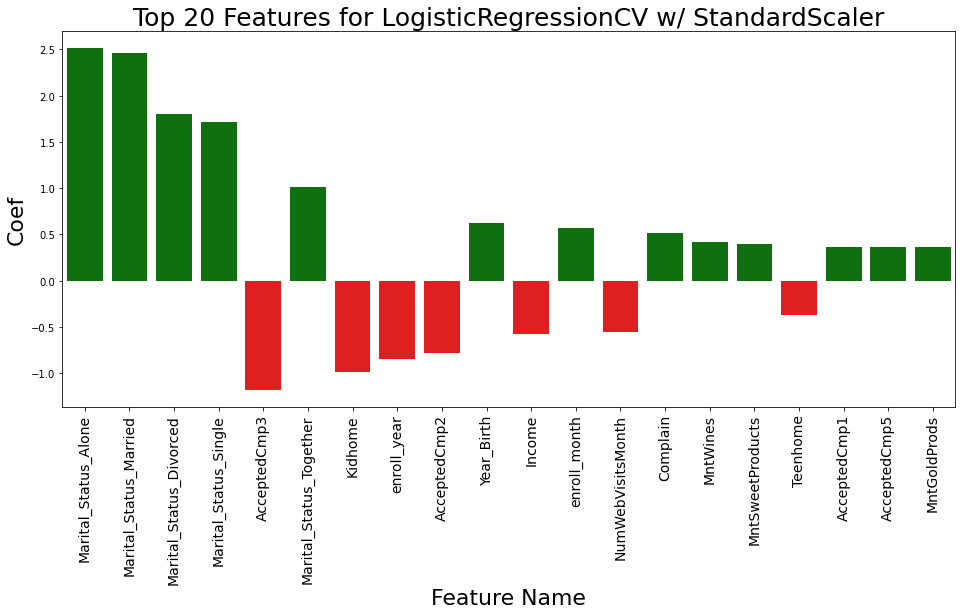

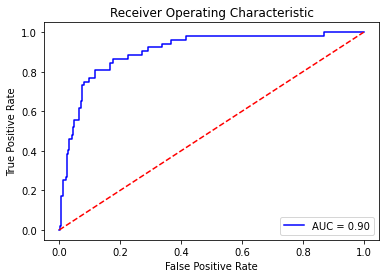

35
Recall:  0.5
Accuracy:  0.8839285714285714
Precision:  0.6666666666666666
F1:  0.5714285714285715


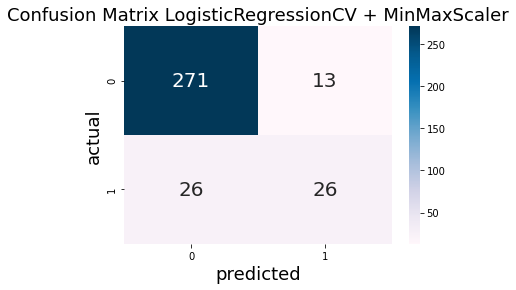

Mean Training Accuracy: 0.9014880952380953 | Standard Deviation: 0.010399645958128673
Mean Validation Accuracy: 0.8919642857142855 | Standard Deviation: 0.010399645958128673


Feature: 0, Score: 1.85863
Feature: 1, Score: -0.01433
Feature: 2, Score: 0.02413
Feature: 3, Score: -1.66963
Feature: 4, Score: -3.12356
Feature: 5, Score: -0.43991
Feature: 6, Score: 0.24416
Feature: 7, Score: 1.70147
Feature: 8, Score: 0.52774
Feature: 9, Score: -0.09103
Feature: 10, Score: 0.51882
Feature: 11, Score: 2.19771
Feature: 12, Score: 1.59944
Feature: 13, Score: 1.19995
Feature: 14, Score: -1.32345
Feature: 15, Score: 1.09379
Feature: 16, Score: 0.09306
Feature: 17, Score: -1.62892
Feature: 18, Score: -3.17398
Feature: 19, Score: 0.15172
Feature: 20, Score: 0.38880
Feature: 21, Score: 0.28721
Feature: 22, Score: -0.71785
Feature: 23, Score: 0.53907
Feature: 24, Score: -0.79352
Feature: 25, Score: 0.46964
Feature: 26, Score: -0.31960
Feature: 27, Score: -0.00021
Feature: 28, Score: 2.27933
Feature: 2

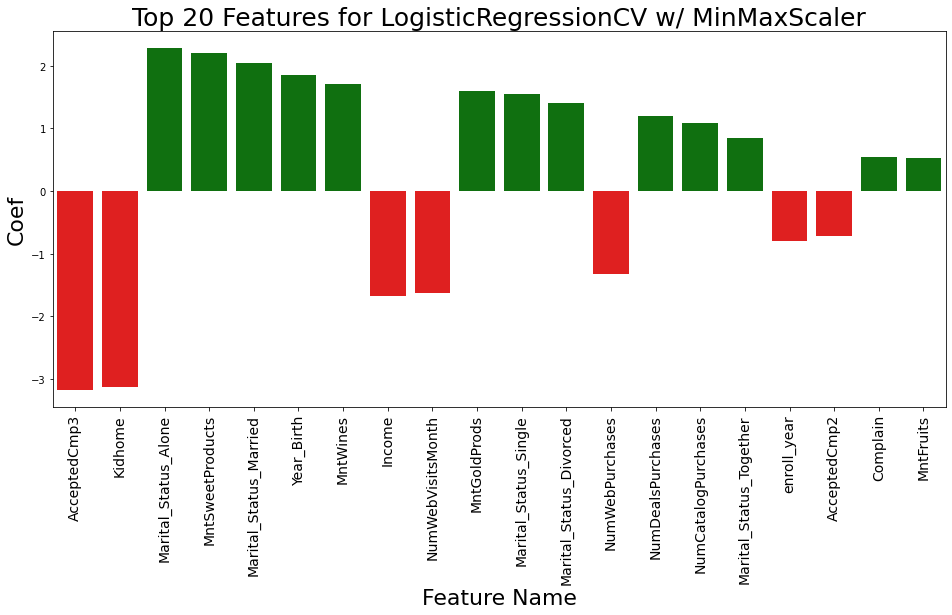

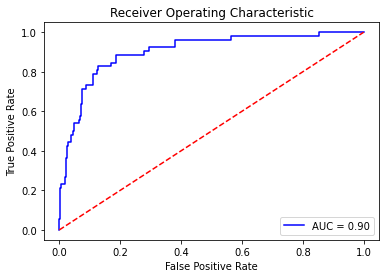

35
Recall:  0.5192307692307693
Accuracy:  0.8869047619047619
Precision:  0.675
F1:  0.5869565217391304


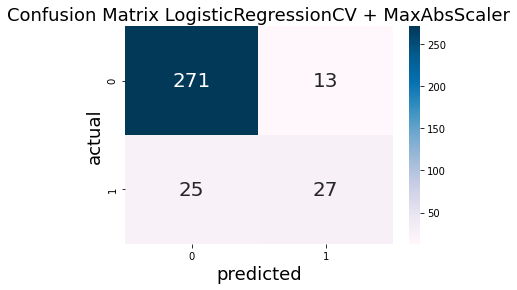

Mean Training Accuracy: 0.8987103174603175 | Standard Deviation: 0.011128812430460449
Mean Validation Accuracy: 0.8902777777777776 | Standard Deviation: 0.011128812430460449


Feature: 0, Score: 1.58946
Feature: 1, Score: -0.28450
Feature: 2, Score: -0.03484
Feature: 3, Score: -1.79883
Feature: 4, Score: -2.95663
Feature: 5, Score: -0.19295
Feature: 6, Score: 0.05294
Feature: 7, Score: 2.42072
Feature: 8, Score: 0.71533
Feature: 9, Score: -0.24718
Feature: 10, Score: 0.81863
Feature: 11, Score: 2.84096
Feature: 12, Score: 2.49140
Feature: 13, Score: 1.42629
Feature: 14, Score: -1.10150
Feature: 15, Score: 2.61319
Feature: 16, Score: -0.12485
Feature: 17, Score: 0.45427
Feature: 18, Score: -0.03959
Feature: 19, Score: 0.40457
Feature: 20, Score: 0.24819
Feature: 21, Score: 0.27506
Feature: 22, Score: -0.61389
Feature: 23, Score: 0.51821
Feature: 24, Score: -0.87351
Feature: 25, Score: 0.45614
Feature: 26, Score: -0.42808
Feature: 27, Score: -0.00177
Feature: 28, Score: 2.23127
Feature: 

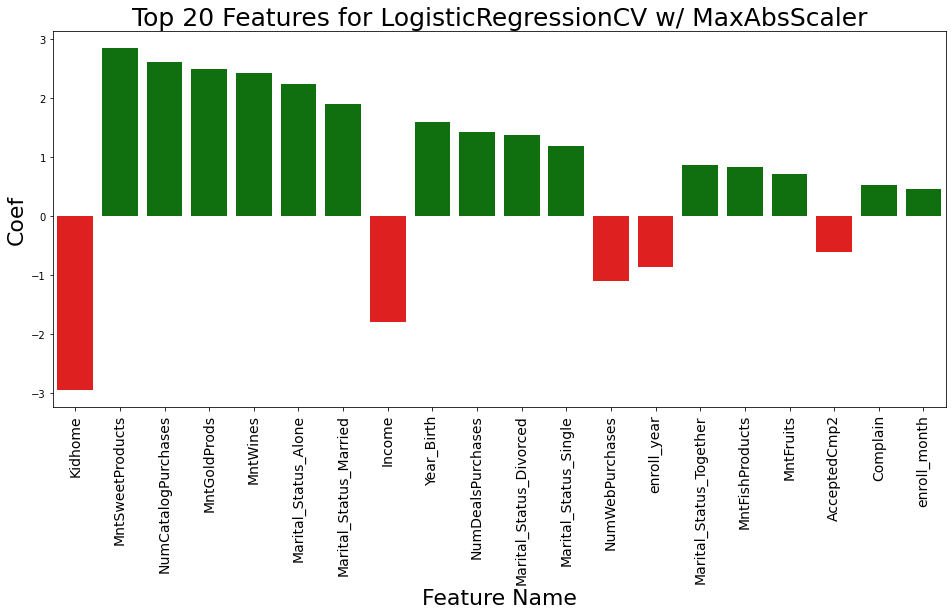

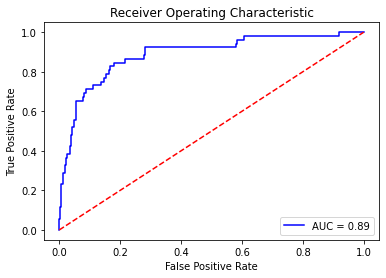

35
Recall:  0.5576923076923077
Accuracy:  0.8869047619047619
Precision:  0.6590909090909091
F1:  0.6041666666666667


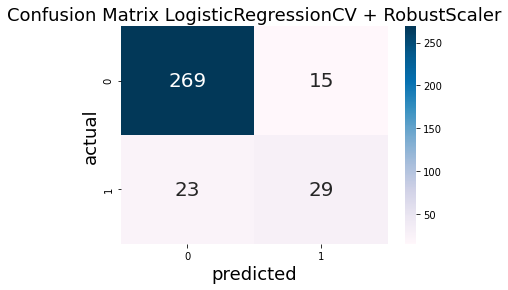

Mean Training Accuracy: 0.8996279761904761 | Standard Deviation: 0.011974313198981464
Mean Validation Accuracy: 0.8906250000000002 | Standard Deviation: 0.011974313198981464


Feature: 0, Score: 0.54007
Feature: 1, Score: -0.27661
Feature: 2, Score: -0.00572
Feature: 3, Score: -1.04524
Feature: 4, Score: -1.70022
Feature: 5, Score: -0.45434
Feature: 6, Score: 0.02630
Feature: 7, Score: 0.38630
Feature: 8, Score: 0.08428
Feature: 9, Score: -0.07384
Feature: 10, Score: 0.06208
Feature: 11, Score: 0.39110
Feature: 12, Score: 0.52453
Feature: 13, Score: 0.45483
Feature: 14, Score: -0.53364
Feature: 15, Score: 0.30312
Feature: 16, Score: 0.07568
Feature: 17, Score: -1.09750
Feature: 18, Score: -1.71867
Feature: 19, Score: 0.10045
Feature: 20, Score: 0.25287
Feature: 21, Score: 0.37988
Feature: 22, Score: -0.75971
Feature: 23, Score: 0.55154
Feature: 24, Score: -0.84917
Feature: 25, Score: 0.49402
Feature: 26, Score: -0.17060
Feature: 27, Score: -0.00158
Feature: 28, Score: 2.45137
Feature: 

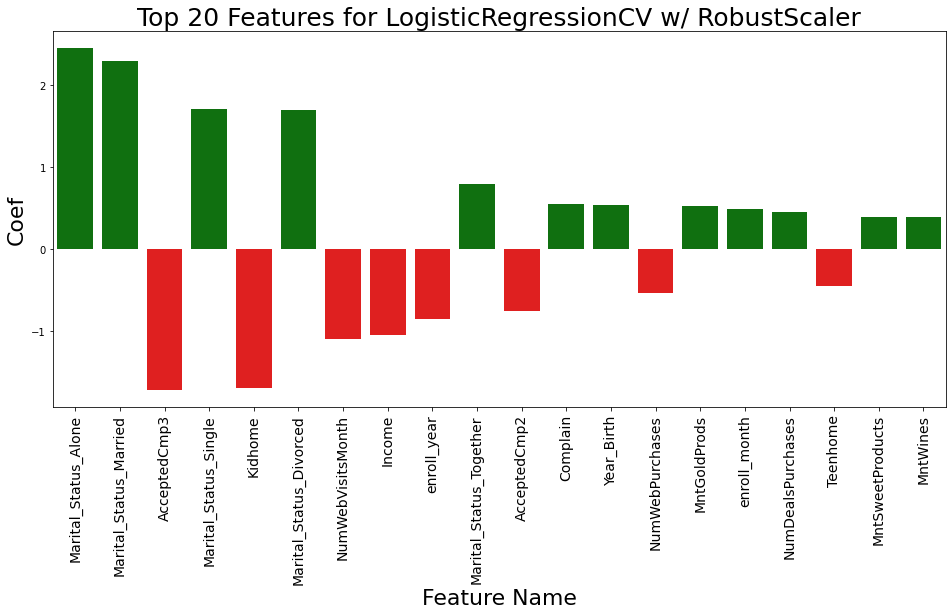

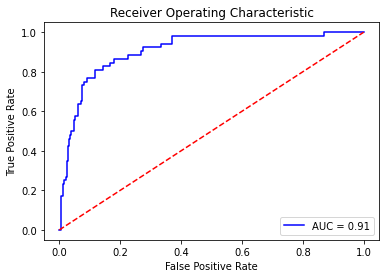

KeyboardInterrupt: 

In [23]:
DATASET_URL = "https://gist.githubusercontent.com/YHYeoh/ad1a7f7170c72d621d05a70637540152/raw/5a6059c199e2c46d2f3d258f03d93cfea98e2749/marketing_campaign.csv"
data = pd.read_csv(DATASET_URL, sep = ';')

pd.set_option('plotting.backend','pandas_bokeh')

data.fillna(method = "ffill", inplace = True)
data.isnull().values.any()

label_encoder = LabelEncoder()
data["Education"] = label_encoder.fit_transform(data["Education"])

data['enroll_year'] = pd.DatetimeIndex(data.Dt_Customer).year
data['enroll_month'] = pd.DatetimeIndex(data.Dt_Customer).month
data['enroll_day'] = pd.DatetimeIndex(data.Dt_Customer).day

data.drop(["ID", 'Dt_Customer',"Z_CostContact","Z_Revenue"], axis=1, inplace=True)

categorical = ['Marital_Status']
numerical = ['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
'Complain', 'enroll_year', 'enroll_month', 'enroll_day']

numerical_no_bool = ['Education','Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits'
, 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases'
, 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth','enroll_day','enroll_month','enroll_year']

y = data.Response
X = data.drop(['Response'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.25)

def cross_validate(classifier, cv):
	scalers = [StandardScaler(),MinMaxScaler(),MaxAbsScaler(), RobustScaler()]
	train_acc = []
	test_acc = []
	mean = []
	result = []
	for scaler in scalers:
		fpr = None
		tpr = None
		preprocess = setupPreprocessPipeline(scaler)
		pipeline = Pipeline(steps=[
			('preprocess', preprocess),
			('classifier', classifier)])
	
		for train_ind, val_ind in cv.split(X_train, y_train):
			X_t, y_t = X_train.iloc[train_ind], y_train.iloc[train_ind]
			pipeline.fit(X_t, y_t)
			y_hat_t = pipeline.predict(X_t)
			train_acc.append(accuracy_score(y_t, y_hat_t))
			X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind] 
			y_hat_val = pipeline.predict(X_val)
			test_acc.append(accuracy_score(y_val, y_hat_val))

		ohe_cols = list(pipeline.named_steps['preprocess'].named_transformers_['cat'].named_steps['ohe'].get_feature_names(input_features=categorical))
		numeric_feature_list = list(numerical)
		for i in ohe_cols:
			numeric_feature_list.append(i)
		print(len(numeric_feature_list))
		evaluation(y_val, y_hat_val, 'Confusion Matrix {} + {}'.format(classifier.__class__.__name__, scaler.__class__.__name__).strip())
		print('Mean Training Accuracy: {} | Standard Deviation: {}'.format(np.mean(train_acc),np.std(test_acc)))
		print('Mean Validation Accuracy: {} | Standard Deviation: {}'.format(np.mean(test_acc),np.std(test_acc)))
		print('\n')
		feature_importance(classifier, numeric_feature_list, scaler.__class__.__name__ )
  
		metrics_summ = None
		if hasmethod(pipeline['classifier'], 'predict_proba'):
			fpr,tpr = ROC_Curve_Plot(pipeline,X_val,y_val)
		result.append({
            'collection':classifier.__class__.__name__+' collection',
            'scalerName':scaler.__class__.__name__,
            'metrics_summ':metrics_summ,
            'fpr':fpr,
            'tpr':tpr
        })
	return result

models = [ 
	LogisticRegressionCV(max_iter= 1200), 
	RidgeClassifierCV(),
	SVC(kernel = 'linear',max_iter= -1), 
	Perceptron(),
	PassiveAggressiveClassifier(), 
	DecisionTreeClassifier(), #no coef 
	KNeighborsClassifier(),#no feat_import, use permutation_importance 
	GaussianNB(), #no feat_import, use permutation_importance 
	LGBMClassifier(),#no coef 
	RandomForestClassifier(), #no coef 
	GradientBoostingClassifier(),#no coef 
	PassiveAggressiveClassifier(), 
	ExtraTreesClassifier(), #no coef 
	XGBClassifier(),
	AdaBoostClassifier(), #no coef 
	]

model_result = []
nameList = []
for model in models:
	print(model.__class__.__name__)
	cross_validate(model,KFold())
	performance = cross_validate(model,KFold())
	model_approximation = [model.__class__.__name__,performance]
	model_result.append(model_approximation)
#another batch for special classifier

#models_permutation = [KNeighborsClassifier(),GaussianNB()]
#enc = OneHotEncoder()
#enc_df = pd.DataFrame(enc.fit_transform(X[["Marital_Status"]]).toarray())
#X = X.join(enc_df)
#X.drop(["Marital_Status"], axis=1, inplace=True)
#columns = X.columns
#X = StandardScaler().fit_transform(X)

In [22]:
#for model_coll in model_result:
#    print(model_coll[0])
#    for eval_type in model_coll:
#        if()
#        print(eval_type[4])
standardScaler = []
minMaxScaler = []
robustScaler = []
robustScaler = []


item = model_result[0][1]
print(item[0][''])




[0.         0.         0.01923077 0.01923077 0.17307692 0.17307692
 0.25       0.25       0.26923077 0.26923077 0.38461538 0.38461538
 0.40384615 0.40384615 0.46153846 0.46153846 0.48076923 0.48076923
 0.51923077 0.51923077 0.55769231 0.55769231 0.61538462 0.61538462
 0.65384615 0.65384615 0.73076923 0.73076923 0.75       0.75
 0.76923077 0.76923077 0.76923077 0.76923077 0.80769231 0.80769231
 0.84615385 0.84615385 0.86538462 0.86538462 0.86538462 0.86538462
 0.88461538 0.88461538 0.90384615 0.90384615 0.92307692 0.92307692
 0.94230769 0.94230769 0.96153846 0.96153846 0.98076923 0.98076923
 0.98076923 1.         1.         1.         1.        ]


for model_coll in model_result:
    result_sum = []
    for eval_type in model_coll:
            print(eval_type[0][0])
        

#obtain nameList
nameList = []
for model in model_result:
    nameList.append(model[0])
#plot all metric
metric_list = ['accuracy','precision','recall','specificity','g_mean'
                   ,'mean_square_error','r2','roc_auc_score','log_loss','f1_score']
for metric in metric_list:
    resultList = []
    for model in model_result:
        resultList.append(model[1][0][metric][1])
    accDF = pd.DataFrame(list(zip(nameList,resultList)),columns=['trained_model',metric])
    plt.title("Models' "+metric)
    ax = sns.barplot(data=accDF.sort_values(metric,ascending=False),orient='h',palette ="Paired" , y = 'trained_model',x=metric)
    plt.show()



#plot auc_curve for predict_proba supported model
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
for model in model_result:
    fpr = model[1][1]
    if(fpr is not None):
        tpr = model[1][2]
        auc = model[1][0]['roc_auc_score'][1]
        result_table = result_table.append({'classifiers':model[0],
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)
        
result_table.set_index('classifiers', inplace=True)
fontP = FontProperties()
fontP.set_size('large')
fig = plt.figure(figsize=(8,6))
for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend( title='Models', bbox_to_anchor=(1.05, 0.85), loc='upper left', prop=fontP)
plt.show()

In [ ]:
# Check for outlier in column
pd.set_option('max_columns', None)
print(data.describe())

# Plot scatter plot and box plot
sns.boxplot(x=data['Income'])
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(data['Response'], data['Income'])
ax.set_xlabel('Response?')
ax.set_ylabel('Income')
plt.show()

#Try to correct the outlier
print(data.dtypes.value_counts())
data = data[(np.abs(stats.zscore(data[['Income']])) < 3)]

In [ ]:
# Plot again to check result
sns.boxplot(x=data['Income'])
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(data['Response'], data['Income'])
ax.set_xlabel('Response?')
ax.set_ylabel('Income')
plt.show()